### Code to do prediction at $24^{th}$ month 

In [1]:
#Importing libraries 
import os
import math
import pandas as pd
import numpy as np
from sklearn import mixture
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis , QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV , cross_val_score,StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.decomposition import PCA as sklearnPCA
import scikitplot as skplt
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics , mixture , svm
import matplotlib.lines as mlines
import seaborn as sns 
from scipy import interp
from itertools import cycle
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import pickle

# h = .02  # step size in the mesh
# mpl.style.use('seaborn-colorblind')
mpl.style.use('seaborn-whitegrid')
import imageio
import warnings
warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline

In [2]:
#Keeping the directory correct
os.chdir('C:\\Users\\Vipul Satone\\health data') # default directory
address = 'C:\\Users\\Vipul Satone\\health data\\ADNI\\sem4\\github_adni_paper_floder\\revision reply\\oct_2020\\fig_adas\\' # directory where images are to be stored

# Create directoy to save processed data and results
if not os.path.exists(address):
    os.makedirs(address)
else:
    print('Directory already present')

Directory already present


In [3]:
# assessment data
cols = {}
list_months_to_be_considered = ['bl','m06','m12']

In [4]:


# Following function gives information about dataset to be imputed.
def data_info(dataset, name):
    print('***********************************************')
    print('Name of dataset is: ' + name) 
    # uncomment below code if you want to print column names in level 0 AND LEVEL 1
#     print('\n0th level of columns is {}'.format(list(pd.Series(dataset.columns.get_level_values(0)).unique()) ) )
#     try:
#         print('\n1st level of columns is: {}'.format(list(pd.Series(dataset.columns.get_level_values(1)).unique()))  )
#     except:
#         pass
    print('\nShape of datset is: {}'.format(dataset.shape ) )
    print('\nTotal number of missing values: {}'.format(dataset.isnull().sum().sum()) )
    print('***********************************************')
    print('\n')



In [5]:
def visualize_unclean_data(Train):
    null_in_cols = Train.isnull().sum()
    null_in_rows = Train.isnull().sum(axis = 1)
    print(Train.isnull().sum().sum())
    if (null_in_cols.sum() != 0):
        fig_1 = plt.figure()
        arr = plt.hist(null_in_rows , bins=np.arange(round(min(null_in_rows)), round(max(null_in_rows)) + null_in_rows.max()/8,null_in_rows.max()/8))
        plt.xlabel('count of features having NULL in them')
        plt.ylabel('Number of observations (that have *bin* \n number of features NULL in them)')
        plt.title('Graph to find out number of most empty observations \n (max null values can be %d)(Rows)' %(Train.shape[1]))
        for i in range(len(arr[0])):
            if (arr[0][i] != 0):
                plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
        fig_1.show()
        fig_2 = plt.figure()
        arr1 = plt.hist(null_in_cols, bins=np.arange(round(min(null_in_cols)), round(max(null_in_cols)) + null_in_cols.max()/8,null_in_cols.max()/8))
        plt.xlabel('count of observations having NULL in them')
        plt.ylabel('Number of features (that have *bin* \n number of observations NULL in them)')
        plt.title('Graph to find out number of most empty features \n (max null values can be %d)(Columns)' %(Train.shape[0]))
        for i in range(len(arr1[0])):
            if (arr1[0][i] != 0):
                plt.text(arr1[1][i],arr1[0][i],str(arr1[0][i]))
        fig_2.show()

In [6]:
# Argument Train1 is dta to be normalized. IF argument b is 'z' the z normalization is done otherwise minmax normalization is done.
def normalize(Train1,b):
    col_names = list(Train1.columns)
    if (b == 'z'):
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - Train1[col_names[i]].mean(skipna = True)) / Train1[col_names[i]].std(skipna = True)
    else:
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - min(Train1[col_names[i]]) )/ ( max(Train1[col_names[i]] ) - min(Train1[col_names[i]]) )
    return Train1

In [7]:
def project_data(M_chosen, visit):

    print(M_chosen.shape)
    M_W_columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_2_1', 'PCA_2_2','ICA_1', 'ICA_2', 'NMF_2_1', 'NMF_2_2', 
               'NMF_3_1', 'NMF_3_2', 'NMF_3_3','ICA_3_1', 'ICA_3_2', 'ICA_3_3']
    M_W = pd.DataFrame(index=M_chosen.index, columns=M_W_columns)
    # PCA
    model_pca = sklearnPCA(n_components=3)
    M_W[['PCA_1', 'PCA_2', 'PCA_3']] = model_pca.fit_transform(M_chosen)
    model_pca = sklearnPCA(n_components=2)
    M_W[['PCA_2_1', 'PCA_2_2']] = model_pca.fit_transform(M_chosen)
    # ICA
    model_ICA = decomposition.FastICA(n_components=2)
    M_W[['ICA_1', 'ICA_2']] = model_ICA.fit_transform(M_chosen)
    model_ICA = decomposition.FastICA(n_components=3)
    M_W[['ICA_3_1', 'ICA_3_2', 'ICA_3_3']] = model_ICA.fit_transform(M_chosen)
    # NMF
    model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
    model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
    M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(M_chosen)
    M_W[['NMF_3_1', 'NMF_3_2', 'NMF_3_3']] = model_NMF3.fit_transform(M_chosen)
    H = model_NMF.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H_T = M_H.T.sort_values(by=[1],ascending=False)
    M_H_T3 = M_H_T
    M_H_T.columns = ['axis 1','axis 2']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+(M_H_T['axis 2'] *0.05) ) \
                               else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +(M_H_T['axis 1']*0.05) ) else 'ambigious', axis=1)
    M_H_T2 = M_H_T
    M_H_T.to_csv(address + "NMF_factorize.csv") 
    cg = sns.clustermap(data=M_H_T3.fillna(0), col_cluster=False, figsize=(30, 40), standard_scale=3)
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=8);
    plt.savefig(address+'\\paper_fig\\'+"NMF_factorize.pdf", dpi = 200,transparent=True)
    plt.title('all features ', fontsize=40)
    plt.show()
    cg_list = list(cg.dendrogram_row.reordered_ind)
    custom_dict  = pd.DataFrame(np.zeros((len(M_H_T),1)))
    list_col_M_H_T3 = list(M_H_T3.index.get_level_values(0))
    for i in range(len(M_H_T3)) :
        custom_dict.iloc[i,0] = list_col_M_H_T3[cg_list[i]]
    custom_dict.to_csv(address + "cluster_sorted_24_2d_list.csv")   
    H = model_NMF3.components_
    H_columns = M_chosen.columns
    M_H = pd.DataFrame(columns=H_columns)
    M_H.loc[0] = H[0,:]
    M_H.loc[1] = H[1,:]
    M_H.loc[2] = H[2,:]
    M_H_T = M_H.T.sort_values(by=[2],ascending=False)
    M_H_T.columns = ['axis 1','axis 2', 'axis 3']
    M_H_T = pd.DataFrame(M_H_T)
    M_H_T = M_H_T.div(M_H_T.sum(axis=1), axis=0)
    M_H_T['new'] = 0
    M_H_T['new'] = M_H_T.apply(lambda M_H_T :  'axis 1' if (M_H_T['axis 1']> M_H_T['axis 2']+M_H_T['axis 3'] ) \
                               else 'axis 2' if (M_H_T['axis 2'] > M_H_T['axis 1'] +M_H_T['axis 3']) else 'axis 3' \
                               if (M_H_T['axis 3'] > M_H_T['axis 1'] +M_H_T['axis 2']) else 'ambigious'  , axis=1)
    M_H_T.to_csv(address + "all_3d_list.csv") 
    M_H_T3 = M_H_T
    redued_data = pd.DataFrame(M_W) # this datset contains all the ICA, PCA and NMF vectors
    # plot the dimension reduction color makrked with participants' "categories", and "gender"
    dignosis = pd.read_csv("ADNI\\Raw_Data\\Assessment\\dxsum.csv",  usecols= ['RID','DXCHANGE','DXMDUE','DXCONFID','VISCODE'])
    dignosis = dignosis[ ~(dignosis['DXCHANGE'].isnull())]
    dignosis = dignosis[ ~(dignosis['DXMDUE'] == 'MCI due to other etiology')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Mildly Confident')]
    dignosis = dignosis[ ~(dignosis['DXCONFID'] == 'Uncertain')]
    dignosis = dignosis[dignosis['RID'].isin(redued_data.index)]
    dignosis = dignosis.set_index('RID')
    dignosis = dignosis[dignosis['VISCODE'] == visit]
    redued = redued_data.merge(dignosis, how = 'inner', left_index = True, right_index = True)
    redued = redued[ ~(redued['DXCHANGE'].isnull())]
    redued.DXCHANGE = redued.DXCHANGE.replace(['Stable: NL to NL', 'Stable: NL','Stable: MCI','Stable: MCI to MCI',\
                                               'Stable: Dementia', 'Stable: Dementia to Dementia','Conversion: NL to MCI',\
                                               'Conversion: MCI to Dementia','Conversion: NL to Dementia','Reversion: MCI to NL', 'Reversion: Dementia to MCI'],[1,1,2,2,3,3,4,5,6,7,8])
    # Replacing the codes as described earlier
    redued.DXCHANGE = redued.DXCHANGE.replace([1,2,3,4,5,6,7,8],[1,2,3,2,3,3,1,2]) 
    colors_categories = redued.DXCHANGE.replace([1,2,3], ['red', 'blue', 'green'])
    return redued[['NMF_2_1','NMF_2_2','DXCHANGE']], colors_categories, M_chosen,dignosis,M_H_T2, M_H_T3

In [8]:
# assessment data
cols = {}
list_months_to_be_considered = ['bl','m06','m12','m24']



with open('list_of_index.pickle', 'rb') as handle:
    inter_list = pickle.load(handle)
    



#CDR
cols['cdr'] = ['RID','VISCODE2', 'CDMEMORY', 'CDORIENT', 'CDJUDGE' ,'CDCOMMUN' ,'CDHOME' ,'CDCARE']
cdr = pd.read_csv("ADNI\\Raw_Data\\Assessment\\CDR.csv",index_col='RID', usecols=cols['cdr'])
cdr1 = cdr.copy(deep = True)
cdr = cdr[cdr['VISCODE2'].isin(['bl','m12','m06','m24']) ]  
inter_list
cdr = cdr.reset_index().set_index(['RID','VISCODE2'])
cdr = cdr[~cdr.index.duplicated()].unstack()
cdr = cdr[ cdr.index.isin(inter_list) ]
cdr = cdr[ (cdr.isnull().sum(axis = 1) <= 4) ]
cdr = cdr.T
cdr = cdr[cdr.index.get_level_values(1).isin(list_months_to_be_considered)].T
# reducing index level
cdr_ruf = cdr.T.reset_index()
cdr_ruf.iloc[:,0]  = 'cdr__' + cdr_ruf.iloc[:,0] +  '____' + cdr_ruf.iloc[:,1]
cdr_ruf = cdr_ruf.set_index('level_0')
cdr = cdr_ruf.iloc[:,1:].T
cdr_no_encoding = cdr
data_info(cdr,'Clinical Dementia Rating')


#NEUROBAT - Just using the total scores CLCOKSCOR, COPYSCOR, BNTTOTAL
cols['neurobat'] = ['RID', 'VISCODE2', 'CLOCKSCOR', 'COPYSCOR', 'LMSTORY', 'LIMMTOTAL', 'LIMMEND',
       'AVTOT1', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3', 'AVERR3', 'AVTOT4',
       'AVERR4', 'AVTOT5', 'AVERR5', 'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB',
       'AVENDED', 'DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH',
       'CATANIMSC', 'CATANPERS', 'CATANINTR', 'CATVEGESC', 'CATVGPERS',
       'CATVGINTR', 'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR',
       'TRABERRCOM', 'TRABERROM', 'DIGITSCOR', 'LDELBEGIN', 'LDELTOTAL',
       'LDELCUE','BNTTOTAL', 'AVDELBEGAN', 'AVDEL30MIN', 'AVDELERR1',
       'AVDELTOT', 'AVDELERR2', 'ANARTND', 'ANARTERR']
neurobat_1 = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat'], index_col = ['RID', 'VISCODE2'])
cols['neurobat_clock'] = ['RID', 'VISCODE2', 'CLOCKSCOR']
neurobat_clock = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_clock'], index_col = ['RID', 'VISCODE2'])
neurobat_clock1 = neurobat_clock.copy(deep = True) 
neurobat_clock = neurobat_clock[~neurobat_clock.index.duplicated()].reset_index()
neurobat_clock = neurobat_clock[neurobat_clock.VISCODE2.isin(['bl','m12','m06','m24'])].set_index(['RID','VISCODE2'])
neurobat_clock = neurobat_clock.unstack()
neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
new_col_list_neurobat_clock = neurobat_clock.columns.levels[0]
for a in new_col_list_neurobat_clock: 
    neurobat_clock[a] = neurobat_clock[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_clock.name = 'Neuropsychological Battery (subdata - clock)'

cols['neurobat_copy'] = ['RID', 'VISCODE2', 'COPYSCOR']
neurobat_copy = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_copy'], index_col = ['RID', 'VISCODE2'])
neurobat_copy1 = neurobat_copy.copy(deep = True) 
neurobat_copy = neurobat_copy[~neurobat_copy.index.duplicated()].reset_index()
neurobat_copy = neurobat_copy[neurobat_copy.VISCODE2.isin(['bl','m12','m06','m24'])].set_index(['RID','VISCODE2'])
neurobat_copy = neurobat_copy.unstack()
neurobat_copy = neurobat_copy[ (neurobat_copy.isnull().sum(axis = 1) <= 1) ]
new_col_list_neurobat_copy = neurobat_copy.columns.levels[0]
for a in new_col_list_neurobat_copy: 
    neurobat_copy[a] = neurobat_copy[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_copy.name = 'Neuropsychological Battery (subdata - copy)'

cols['neurobat_limm_story'] = ['RID', 'VISCODE2', 'LIMMTOTAL']
neurobat_limm_story = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_limm_story'], index_col = ['RID', 'VISCODE2'])
neurobat_limm_story1 = neurobat_limm_story.copy(deep = True) 
neurobat_limm_story = neurobat_limm_story[~neurobat_limm_story.index.duplicated()].reset_index()
neurobat_limm_story = neurobat_limm_story[neurobat_limm_story.VISCODE2.isin(['bl','m12','m06','m24'])].set_index(['RID','VISCODE2'])
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_limm_story = neurobat_limm_story.unstack()
neurobat_limm_story = neurobat_limm_story.drop(['m06','bl'], axis=1, level=1)
#neurobat_limm_story = neurobat_limm_story.T[ (neurobat_limm_story.columns.levels[1]) == 'm12' ].T
neurobat_limm_story = neurobat_limm_story[ (neurobat_limm_story.isnull().sum(axis = 1) < 1) ]
neurobat_limm_story.name = 'Neuropsychological Battery (subdata - story)'

cols['neurobat_dspan'] = ['RID', 'VISCODE2','DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH']
neurobat_dspan = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_dspan'], index_col = ['RID', 'VISCODE2'])
neurobat_dspan1 = neurobat_dspan.copy(deep = True) 
neurobat_dspan = neurobat_dspan[~neurobat_dspan.index.duplicated()].reset_index()
neurobat_dspan = neurobat_dspan[neurobat_dspan.VISCODE2.isin(['bl','m12','m06','m24'])].set_index(['RID','VISCODE2'])
neurobat_dspan = neurobat_dspan[ (neurobat_dspan.isnull().sum(axis = 1) < 4) ]
neurobat_dspan = neurobat_dspan.unstack()
neurobat_dspan = neurobat_dspan[ (neurobat_dspan.isnull().sum(axis = 1) <6) ]
new_col_list_neurobat_dspan = neurobat_dspan.columns.levels[0]
for a in new_col_list_neurobat_dspan: 
    neurobat_dspan[a] = neurobat_dspan[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_dspan.name = 'Neuropsychological Battery (subdata - digit span)'

cols['neurobat_cat_flu'] = ['RID', 'VISCODE2','CATANIMSC', 'CATANPERS', 'CATANINTR', 'CATVEGESC', 'CATVGPERS','CATVGINTR']
neurobat_cat_flu = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_cat_flu'], index_col = ['RID', 'VISCODE2'])
neurobat_cat_flu1 = neurobat_cat_flu.copy(deep = True) 
neurobat_cat_flu = neurobat_cat_flu[~neurobat_cat_flu.index.duplicated()].reset_index()
neurobat_cat_flu = neurobat_cat_flu[neurobat_cat_flu.VISCODE2.isin(['bl','m12','m06','m24'])].set_index(['RID','VISCODE2'])
neurobat_cat_flu = neurobat_cat_flu.replace({-1: np.NAN})
neurobat_cat_flu = neurobat_cat_flu[ (neurobat_cat_flu.isnull().sum(axis = 1) < 4) ]
del neurobat_cat_flu['CATVEGESC']
del neurobat_cat_flu['CATVGPERS']
del neurobat_cat_flu['CATVGINTR']
neurobat_cat_flu = neurobat_cat_flu.unstack()
neurobat_cat_flu = neurobat_cat_flu[ (neurobat_cat_flu.isnull().sum(axis = 1) <4) ]
new_col_list_neurobat_cat_flu = neurobat_cat_flu.columns.levels[0]
for a in new_col_list_neurobat_cat_flu: 
    neurobat_cat_flu[a] = neurobat_cat_flu[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_cat_flu.name = 'Neuropsychological Battery (subdata - category fluency : only animal examples)'

cols['neurobat_trail'] = ['RID', 'VISCODE2', 'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR','TRABERRCOM', 'TRABERROM']
neurobat_trail = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_trail'], index_col = ['RID', 'VISCODE2'])
neurobat_trail1 = neurobat_trail.copy(deep = True) 
neurobat_trail = neurobat_trail[~neurobat_trail.index.duplicated()].reset_index()
neurobat_trail = neurobat_trail[neurobat_trail.VISCODE2.isin(['bl','m12','m06','m24'])].set_index(['RID','VISCODE2'])
neurobat_trail = neurobat_trail[ (neurobat_trail.isnull().sum(axis = 1) < 3) ]
neurobat_trail = neurobat_trail.unstack()
neurobat_trail = neurobat_trail[ (neurobat_trail.isnull().sum(axis = 1) <=6) ]
new_col_list_neurobat_trail = neurobat_trail.columns.levels[0]
for a in new_col_list_neurobat_trail: 
    neurobat_trail[a] = neurobat_trail[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_trail.name = 'Neuropsychological Battery (subdata - Trail making)'

cols['neurobat_av'] = ['RID', 'VISCODE2','AVTOT1', 'AVDELERR1','AVDELTOT', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3',     'AVERR3','AVDELERR2', 'AVTOT4','AVERR4', 'AVTOT5', 'AVERR5', 'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB','AVDEL30MIN']
neurobat_av = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_av'], index_col = ['RID', 'VISCODE2'])
neurobat_av1 = neurobat_av.copy(deep = True) 
neurobat_av = neurobat_av[~neurobat_av.index.duplicated()].reset_index()
neurobat_av = neurobat_av[neurobat_av.VISCODE2.isin(['bl','m12','m06','m24'])].set_index(['RID','VISCODE2'])
neurobat_av = neurobat_av.unstack()
neurobat_av = neurobat_av[ (neurobat_av.isnull().sum(axis = 1) <25) ]
new_col_list_neurobat_av = neurobat_av.columns.levels[0]
for a in new_col_list_neurobat_av: 
    neurobat_av[a] = neurobat_av[a].interpolate(method='linear', axis=1, limit=2, limit_direction='both')
neurobat_av.name = 'Neuropsychological Battery (subdata - av)'

cols['neurobat_digit_score'] = ['RID', 'VISCODE2','DIGITSCOR']
neurobat_digit_score = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_digit_score'], index_col = ['RID', 'VISCODE2'])
neurobat_digit_score1 = neurobat_digit_score.copy(deep = True) 
neurobat_digit_score = neurobat_digit_score[~neurobat_digit_score.index.duplicated()].reset_index()
neurobat_digit_score = neurobat_digit_score[neurobat_digit_score.VISCODE2.isin(['bl','m12','m06','m24'])].set_index(['RID','VISCODE2'])
neurobat_digit_score = neurobat_digit_score[ (neurobat_digit_score.isnull().sum(axis = 1) < 1) ]
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_digit_score = neurobat_digit_score.unstack()
neurobat_digit_score = neurobat_digit_score[ (neurobat_digit_score.isnull().sum(axis = 1) <=1) ]
new_col_list_neurobat_digit_score = neurobat_digit_score.columns.levels[0]
for a in new_col_list_neurobat_digit_score: 
    neurobat_digit_score[a] = neurobat_digit_score[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_digit_score.name = 'Neuropsychological Battery (subdata - digit score)'


cols['neurobat_boston_naming_test'] = ['RID', 'VISCODE2', 'BNTSPONT','BNTSTIM','BNTCSTIM','BNTPHON','BNTCPHON']
neurobat_boston_naming_test = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_boston_naming_test'], index_col = ['RID', 'VISCODE2'])
neurobat_boston_naming_test1 = neurobat_boston_naming_test.copy(deep = True) 
neurobat_boston_naming_test = neurobat_boston_naming_test[~neurobat_boston_naming_test.index.duplicated()].reset_index()
neurobat_boston_naming_test = neurobat_boston_naming_test[neurobat_boston_naming_test.VISCODE2.isin(['bl','m12','m06','m24'])].set_index(['RID','VISCODE2'])
neurobat_boston_naming_test = neurobat_boston_naming_test[ (neurobat_boston_naming_test.isnull().sum(axis = 1) < 5) ]
neurobat_boston_naming_test = neurobat_boston_naming_test.unstack()
neurobat_boston_naming_test = neurobat_boston_naming_test[ (neurobat_boston_naming_test.isnull().sum(axis = 1) <6) ]
new_col_list_neurobat_boston_naming_test = neurobat_boston_naming_test.columns.levels[0]
for a in new_col_list_neurobat_boston_naming_test: 
    neurobat_boston_naming_test[a] = neurobat_boston_naming_test[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_boston_naming_test.name = 'Neuropsychological Battery (subdata - Boston naming test)'



cols['neurobat_anrt'] = ['RID', 'VISCODE2', 'ANARTND']
neurobat_anrt = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat_anrt'], index_col = ['RID', 'VISCODE2'])
neurobat_anrt1 = neurobat_anrt.copy(deep = True) 
neurobat_anrt = neurobat_anrt[~neurobat_anrt.index.duplicated()].reset_index()
neurobat_anrt = neurobat_anrt[neurobat_anrt.VISCODE2.isin(['bl','m12','m06','m24'])].set_index(['RID','VISCODE2'])
neurobat_anrt = neurobat_anrt[ (neurobat_anrt.isnull().sum(axis = 1) < 1) ]
#neurobat_clock = neurobat_clock[ (neurobat_clock.isnull().sum(axis = 1) <= 1) ]
neurobat_anrt = neurobat_anrt.unstack()
neurobat_anrt = neurobat_anrt[ (neurobat_anrt.isnull().sum(axis = 1) <=1) ]
new_col_list_neurobat_anrt = neurobat_anrt.columns.levels[0]
for a in new_col_list_neurobat_anrt: 
    neurobat_anrt[a] = neurobat_anrt[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
neurobat_anrt.name = 'Neuropsychological Battery (subdata - American national reading test)'


neurobat1 = pd.merge(neurobat_clock,neurobat_copy , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_limm_story , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_av , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_cat_flu , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_trail , left_index = True, right_index = True, how='inner')
# neurobat1 = pd.merge(neurobat1,neurobat_logical_memory , left_index = True, right_index = True, how='inner')
neurobat1 = pd.merge(neurobat1,neurobat_boston_naming_test , left_index = True, right_index = True, how='inner')
neurobat1 = neurobat1.T
neurobat1 = neurobat1[neurobat1.index.get_level_values(1).isin(['bl','m12','m06','m24'])].T
# reducing index level
neurobat1_ruf = neurobat1.T.reset_index()
neurobat1_ruf.iloc[:,0]  = 'neurobat__' + neurobat1_ruf.iloc[:,0] +  '____' + neurobat1_ruf.iloc[:,1]
neurobat1_ruf = neurobat1_ruf.set_index('level_0')
neurobat1 = neurobat1_ruf.iloc[:,1:].T
neurobat1_no_encoding = neurobat1
neurobat = neurobat1


data_info(neurobat,'Neuropsychological Battery (All combined)')


#MMSE
#cols['mmse'] = ['RID', 'VISCODE2','MMSCORE','MMDATE','MMYEAR','MMMONTH','MMDAY','MMSEASON','MMHOSPIT',    'MMFLOOR','MMCITY','MMAREA','MMSTATE','MMBALL','MMFLAG','MMTREE','MMD','MML','MMR','MMO','MMW',    'MMBALLDL','MMFLAGDL','MMTREEDL','MMWATCH','MMPENCIL','MMREPEAT','MMHAND','MMFOLD','MMONFLR','MMREAD',    'MMWRITE','MMDRAW']
cols['mmse'] = ['RID', 'VISCODE2','MMSCORE']

mmse = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MMSE.csv', usecols=cols['mmse'], index_col = ['RID', 'VISCODE2'])
mmse1 = mmse.copy(deep = True)
mmse = mmse[~mmse.index.duplicated()].reset_index()
mmse = mmse[mmse.VISCODE2.isin(['bl','m06','m12','m24'])].set_index(['RID','VISCODE2'])

mmse = mmse.replace({-4:np.NAN})
mmse = mmse.replace({-1:np.NAN})
mmse = mmse[ (mmse.isnull().sum(axis = 1) ==0 ) ]
mmse = mmse.unstack()
mmse = mmse[ (mmse.isnull().sum(axis = 1) < 2) ]
mmse = mmse[~mmse.index.duplicated()]
mmse = mmse[ mmse.index.isin(inter_list) ]
mmse = mmse.interpolate(method='linear', axis=1, limit=1, limit_direction='both')
mmse = mmse.T
mmse = mmse[mmse.index.get_level_values(1).isin(['bl','m06','m12','m24'])].T
# reducing index level
mmse_ruf = mmse.T.reset_index()
mmse_ruf.iloc[:,0]  = 'mmse__' + mmse_ruf.iloc[:,0] +  '_____' + mmse_ruf.iloc[:,1]
mmse_ruf = mmse_ruf.set_index('level_0')
mmse = mmse_ruf.iloc[:,1:].T
mmse_no_encoding = mmse  
mmse = mmse_no_encoding 
data_info(mmse,'Mini Mental State Exam')



#GERIATRIC
cols['geriatric'] = ['VISCODE2', 'RID', 'GDTOTAL']
geriatric = pd.read_csv("ADNI\\Raw_Data\\Assessment\\GDSCALE.csv", index_col='RID', usecols=cols['geriatric'])
geriatric1 = geriatric.copy(deep = True)
geriatric = geriatric.replace({-4:np.NAN})
geriatric = geriatric.replace({-1:np.NAN})
geriatric = geriatric[geriatric['VISCODE2'].isin(['bl','m12','m06','m24']) ]  
geriatric = geriatric.reset_index().set_index(['RID','VISCODE2'])
geriatric = geriatric[ (geriatric.isnull().sum(axis = 1) ==0) ]
geriatric = geriatric[~geriatric.index.duplicated()].unstack()
geriatric = geriatric[ (geriatric.isnull().sum(axis = 1) ==0) ]
geriatric = geriatric.T
geriatric = geriatric[geriatric.index.get_level_values(1).isin(['bl','m12','m06','m24'])].T
# reducing index level
geriatric_ruf = geriatric.T.reset_index()
geriatric_ruf.iloc[:,0]  = 'gd_scale__' + geriatric_ruf.iloc[:,0] +  '____' + geriatric_ruf.iloc[:,1]
geriatric_ruf = geriatric_ruf.set_index('level_0')
geriatric = geriatric_ruf.iloc[:,1:].T
geriatric_no_encoding = geriatric
data_info(geriatric,'Geriatric depression scale')


#UWNPSYCHSUM_10_27_17
cols['UWNPSYCHSUM_10_27_17'] = ['RID', 'VISCODE2', 'ADNI_MEM', 'ADNI_EF']
uwn = pd.DataFrame(pd.read_csv("ADNI\\Raw_Data\\Assessment\\UWNPSYCHSUM_10_27_17.csv",index_col= ['RID','VISCODE2'], usecols=cols['UWNPSYCHSUM_10_27_17']))
uwn1 = uwn.copy(deep = True)
uwn = uwn[~uwn.index.duplicated()].reset_index()
uwn = uwn[uwn.VISCODE2.isin(['bl','m06','m12','m24'])].set_index(['RID','VISCODE2'])
uwn = uwn[~uwn.index.duplicated()].unstack()
uwn = uwn[ (uwn.isnull().sum(axis = 1) < 3) ]
new_col_list_uwn = uwn.columns.levels[0]
uwn = uwn[ uwn.index.isin(inter_list) ]
for a in new_col_list_uwn: 
    uwn[a] = uwn[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
uwn = uwn[ (uwn.isnull().sum(axis = 1) <1) ]
uwn = uwn.T
uwn = uwn[uwn.index.get_level_values(1).isin(['bl','m06','m12','m24'])].T
# reducing index level
uwn_ruf = uwn.T.reset_index()
uwn_ruf.iloc[:,0]  = 'UW__' + uwn_ruf.iloc[:,0] +  '____' + uwn_ruf.iloc[:,1]
uwn_ruf = uwn_ruf.set_index('level_0')
uwn = uwn_ruf.iloc[:,1:].T
uwn_no_encoding = uwn
data_info(uwn,'Crane Lab (UW) Neuropsych Summary Score')


#NPI
cols['npi'] = ['RID', 'VISCODE2','NPIATOT', 'NPICTOT',  'NPIDTOT',     'NPIETOT', 'NPIGTOT', 'NPIHTOT', 'NPIITOT', 'NPIJTOT','NPIKTOT', 'NPILTOT']
npi = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NPI.csv', usecols=cols['npi'], index_col = ['RID', 'VISCODE2'])
npi1 = npi.copy(deep = True)
npi = npi[~npi.index.duplicated()].reset_index()
# m12 only
npi_m12 = npi[npi.VISCODE2.isin(['m12'])].set_index(['RID','VISCODE2'])
npi_m12 = npi_m12[~npi_m12.index.duplicated()].unstack()
npi_m12 = npi_m12[ (npi_m12.isnull().sum(axis = 1) < 12) ]
# baseline
npi_bl = npi[npi.VISCODE2.isin(['bl'])].set_index(['RID','VISCODE2'])
npi_bl = npi_bl[~npi_bl.index.duplicated()].unstack()
npi_bl = npi_bl[ (npi_bl.isnull().sum(axis = 1) < 12) ]
# both baseline and m12
npi_all = npi[npi.VISCODE2.isin(['bl','m06','m12','m24'])].set_index(['RID','VISCODE2'])
npi_all = npi_all[~npi_all.index.duplicated()].unstack()
npi_all = npi_all[ (npi_all.isnull().sum(axis = 1) < 10) ]
npi_all = npi_all.T
npi_all = npi_all[npi_all.index.get_level_values(1).isin(['bl','m06','m12','m24'])].T
# reducing index level
npi_all_ruf = npi_all.T.reset_index()
npi_all_ruf.iloc[:,0]  = 'npi_all__' + npi_all_ruf.iloc[:,0] +  '____' + npi_all_ruf.iloc[:,1]
npi_all_ruf = npi_all_ruf.set_index('level_0')
npi_all = npi_all_ruf.iloc[:,1:].T
npi_all_no_encoding = npi_all
data_info(npi_all,'Neuro Inventory')



#MOCA 
cols['moca'] = ['RID','VISCODE2', 'TRAILS', 'CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN','LION', 'RHINO', 'CAMEL', 'IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4',
       'IMMT1W5', 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5','DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3',
       'SERIAL4', 'SERIAL5', 'REPEAT1', 'REPEAT2', 'FFLUENCY', 'ABSTRAN','ABSMEAS', 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5', 'DATE', 'MONTH',
       'YEAR', 'DAY', 'PLACE', 'CITY']

cols['moca_trail_making'] = ['TRAILS']
cols['moca_visuosoconstructional'] = ['CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN']
cols['moca_naming'] = [ 'LION', 'RHINO', 'CAMEL']
cols['moca_immediate_recall'] = [ 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5','IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4', 'IMMT1W5']
cols['moca_attention'] = [ 'DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3','SERIAL4', 'SERIAL5']
cols['moca_sen_repetetion'] = ['REPEAT1','REPEAT2']
cols['moca_fluency'] = ['FFLUENCY']
cols['moca_abstraction'] = ['ABSTRAN','ABSMEAS']
cols['moca_delayed_word_recall'] = [ 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5']
cols['moca_orientation'] = [ 'DATE', 'MONTH', 'YEAR', 'DAY', 'PLACE', 'CITY' ]
moca = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MOCA.csv', usecols=cols['moca'], index_col = ['RID', 'VISCODE2'])
moca['moca_trail_making'] = moca[cols['moca_trail_making']].sum(axis=1)
moca['moca_visuosoconstructional'] = moca[cols['moca_visuosoconstructional']].sum(axis=1)
moca['moca_naming'] = moca[cols['moca_naming']].sum(axis = 1)
moca['moca_immediate_recall'] = moca[cols['moca_immediate_recall']].sum(axis=1)
moca['moca_attention'] = moca[cols['moca_attention']].sum(axis=1)
moca['moca_sen_repetetion'] = moca[cols['moca_sen_repetetion']].sum(axis=1)
moca['moca_fluency'] = moca[cols['moca_fluency']].sum(axis=1)
moca['moca_abstraction'] = moca[cols['moca_abstraction']].sum(axis=1)
moca['moca_delayed_word_recall'] = moca[cols['moca_delayed_word_recall']].sum(axis=1)
moca['moca_orientation'] = moca[cols['moca_orientation']].sum(axis=1)
moca = moca[['moca_trail_making', 'moca_visuosoconstructional', 'moca_naming', 'moca_attention', 'moca_immediate_recall',             'moca_sen_repetetion', 'moca_fluency','moca_abstraction','moca_delayed_word_recall','moca_orientation']] # drop extra
moca1 = moca.copy(deep = True) 
#Dropping the Duplicated Index (Only 1)
moca = moca[~moca.index.duplicated()].reset_index()
moca = moca[moca.VISCODE2.isin(['bl','m06','m12','m24'])].set_index(['RID','VISCODE2'])
moca = moca.unstack()
moca = moca[ (moca.isnull().sum(axis = 1) < 15) ]
new_col_list_moca = moca.columns.levels[0]
moca = moca[ moca.index.isin(inter_list) ]
for a in new_col_list_moca: 
    moca[a] = moca[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
moca = moca.T
moca = moca[moca.index.get_level_values(1).isin(['bl','m06','m12','m24'])].T
  
    
# reducing index level
moca_ruf = moca.T.reset_index()
moca_ruf.iloc[:,0]  = 'moca__' + moca_ruf.iloc[:,0] +  '____' + moca_ruf.iloc[:,1]
moca_ruf = moca_ruf.set_index('level_0')
moca = moca_ruf.iloc[:,1:].T
moca_no_encoding = moca  
moca = moca_no_encoding
data_info(moca,'Montreal Cognitive Assessment')





#FAQ
cols['faq'] = ['RID', 'VISCODE2', 'FAQTOTAL']
faq = pd.read_csv('ADNI\\Raw_Data\\Assessment\\FAQ.csv', usecols=cols['faq'], index_col = ['RID', 'VISCODE2'])
faq1 = faq.copy(deep = True) 
faq = faq[~faq.index.duplicated()].reset_index()
faq = faq[faq.VISCODE2.isin(['bl','m06','m12','m24'])].set_index(['RID','VISCODE2'])
faq = faq[~faq.index.duplicated()]
#Unstacking 
faq = faq.unstack()
faq = faq[ (faq.isnull().sum(axis = 1) < 2) ]
new_col_list_faq = faq.columns.levels[0]
faq = faq[ faq.index.isin(inter_list) ]
for a in new_col_list_faq: 
    faq[a] = faq[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    
faq = faq.T
faq = faq[faq.index.get_level_values(1).isin(['bl','m06','m12','m24'])].T
      
# reducing index level
faq_ruf = faq.T.reset_index()
faq_ruf.iloc[:,0]  = 'FAQ__' + faq_ruf.iloc[:,0] +  '____' + faq_ruf.iloc[:,1]
faq_ruf = faq_ruf.set_index('level_0')
faq = faq_ruf.iloc[:,1:].T
faq_no_encoding = faq  
faq = faq_no_encoding
data_info(faq,'Functional Assessment Questionnaire')


#EXOGPT
cols['ecogpt'] =  ['RID', 'VISCODE2',        'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']
ecogpt = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ecogpt.csv",index_col='RID', usecols=cols['ecogpt'])

list_memory = [ 'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8']
list_lang = ['LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9']
list_vis = ['VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8']
list_plan = ['PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5']
list_org = ['ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6']
list_div = ['DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']

ecogpt_new = pd.DataFrame()
ecogpt1 = ecogpt.copy(deep = True)
ecogpt = ecogpt.replace({9: np.nan })
ecogpt = ecogpt[ecogpt['VISCODE2'].isin(['bl','m12','m06','m24']) ]  
ecogpt = ecogpt.reset_index().set_index(['RID','VISCODE2'])
ecogpt = ecogpt[~ecogpt.index.duplicated()]
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) <= 30) ]
ecogpt = ecogpt.unstack()
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) < 61) ]
new_col_list_ecogpt = ecogpt.columns.levels[0]
ecogpt = ecogpt[ ecogpt.index.isin(inter_list) ]
for a in new_col_list_ecogpt: 
    ecogpt[a] = ecogpt[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    
ecogpt = ecogpt.T
ecogpt_bl = ecogpt[ecogpt.index.get_level_values(1).isin(['bl'])]
ecogpt_m06 = ecogpt[ecogpt.index.get_level_values(1).isin(['m06'])]
ecogpt_m12 = ecogpt[ecogpt.index.get_level_values(1).isin(['m12'])]
ecogpt_m24 = ecogpt[ecogpt.index.get_level_values(1).isin(['m24'])]

ecogpt_new['memory_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_bl']  =  ecogpt_bl[ecogpt_bl.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogpt_new['memory_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m06']  =  ecogpt_m06[ecogpt_m06.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogpt_new['memory_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m12']  =  ecogpt_m12[ecogpt_m12.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )


ecogpt_new['memory_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogpt_new['lang_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogpt_new['vis_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogpt_new['plan_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogpt_new['org_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogpt_new['division_m24']  =  ecogpt_m24[ecogpt_m24.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

# reducing index level
ecogpt_ruf = ecogpt_new.T.reset_index()
ecogpt_ruf.iloc[:,0]  = 'ecogpt___'  + ecogpt_ruf.iloc[:,0]
ecogpt_ruf = ecogpt_ruf.set_index(['index'])
ecogpt_ruf = ecogpt_ruf.T
ecogpt_no_encoding = ecogpt_ruf
ecogpt = ecogpt_no_encoding  
ecogpt = ecogpt[ ecogpt.isnull().sum(axis =1) == 0 ]
ecogpt.columns = [i.split('_')[0] + '__' + i.split('_')[-2] + '____' + i.split('_')[-1] for i in list( ecogpt.columns )]
data_info(ecogpt,'Everyday Cognition Partner')
ecogpt.name = 'Everyday cognition - study partner'


#EXOGSP
cols['ecogsp'] =  ['RID', 'VISCODE2',        'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']
ecogsp = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ECOGSP.csv",index_col='RID', usecols=cols['ecogsp'])

list_memory = [ 'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',       'MEMORY6', 'MEMORY7', 'MEMORY8']
list_lang = ['LANG1', 'LANG2', 'LANG3', 'LANG4',       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9']
list_vis = ['VISSPAT1', 'VISSPAT2',       'VISSPAT3', 'VISSPAT4', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8']
list_plan = ['PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5']
list_org = ['ORGAN1', 'ORGAN2',       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6']
list_div = ['DIVATT1', 'DIVATT2', 'DIVATT3',       'DIVATT4']

ecogsp_new = pd.DataFrame()
ecogsp1 = ecogsp.copy(deep = True)
print(ecogsp1.shape)
ecogsp = ecogsp.replace({9: np.nan })
ecogsp = ecogsp[ecogsp['VISCODE2'].isin(['bl','m12','m06','m24']) ]  
ecogsp = ecogsp.reset_index().set_index(['RID','VISCODE2'])
ecogsp = ecogsp[~ecogsp.index.duplicated()]
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) <= 30) ]
ecogsp = ecogsp.unstack()
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) < 50) ]
new_col_list_ecogsp = ecogsp.columns.levels[0]
ecogsp = ecogsp[ ecogsp.index.isin(inter_list) ]
for a in new_col_list_ecogsp: 
    ecogsp[a] = ecogsp[a].interpolate(method='linear', axis=1, limit=1, limit_direction='both')
    

ecogsp = ecogsp.T
ecogsp_bl = ecogsp[ecogsp.index.get_level_values(1).isin(['bl'])]
ecogsp_m06 = ecogsp[ecogsp.index.get_level_values(1).isin(['m06'])]
ecogsp_m12 = ecogsp[ecogsp.index.get_level_values(1).isin(['m12'])]
ecogsp_m24 = ecogsp[ecogsp.index.get_level_values(1).isin(['m24'])]
    
ecogsp_new['memory_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_bl']  =  ecogsp_bl[ecogsp_bl.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m06']  =  ecogsp_m06[ecogsp_m06.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m12']  =  ecogsp_m12[ecogsp_m12.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

ecogsp_new['memory_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_memory)].mean( axis = 0, skipna = True  )
ecogsp_new['lang_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_lang)].mean( axis = 0, skipna = True  )
ecogsp_new['vis_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_vis)].mean( axis = 0, skipna = True  )
ecogsp_new['plan_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_plan)].mean( axis = 0, skipna = True  )
ecogsp_new['org_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_org)].mean( axis = 0, skipna = True  )
ecogsp_new['division_m24']  =  ecogsp_m24[ecogsp_m24.index.get_level_values(0).isin(list_div)].mean( axis = 0, skipna = True  )

# reducing index level
ecogsp_ruf = ecogsp_new.T.reset_index()
ecogsp_ruf.iloc[:,0]  = 'ecogsp___'  + ecogsp_ruf.iloc[:,0]
ecogsp_ruf = ecogsp_ruf.set_index(['index'])
ecogsp_ruf = ecogsp_ruf.T
ecogsp_no_encoding = ecogsp_ruf 
ecogsp = ecogsp_no_encoding   
# ecogsp = ecogsp[ ecogsp.isnull().sum(axis =1) == 0 ]
ecogsp.columns = [i.split('_')[0] + '__' + i.split('_')[-2] + '____' + i.split('_')[-1] for i in list( ecogsp.columns )]
data_info(ecogsp,'Everyday Cognition - self')




adas = pd.read_csv('ADNI\\Raw_Data\\Assessment\\ADAS_ADNIGO23.csv')
adas = adas[ ['RID','VISCODE2','TOTAL13','TOTSCORE'] ]
adas = adas[adas['VISCODE2'].isin(['bl','m12','m06']) ]  
adas = adas.set_index(['RID','VISCODE2'])
adas = adas.unstack()
adas_rid_list = adas[ adas.isnull().sum(axis = 1) >0 ].index


new_col_list_adas = adas.columns.levels[0]
for a in new_col_list_adas: 
    adas[a] = adas[a].interpolate(method='linear', axis=1, limit=2, limit_direction='both')

adas = adas.T
adas = adas[adas.index.get_level_values(1).isin(['bl','m06','m12','m24'])].T


# reducing index level
adas_ruf = adas.T.reset_index()
adas_ruf.iloc[:,0]  = 'adas__'  + adas_ruf['level_0']+  '____' + adas_ruf['VISCODE2']
adas_ruf = adas_ruf.set_index(['level_0'])
adas_ruf = adas_ruf.T
adas_no_encoding = adas_ruf
adas = adas_no_encoding   
data_info(adas,'ADAS')


# datasets and visits of interest
# dict_datasets dictionary will contain all the data sets.
# common_rids is a list of all the common ridsin the datset
datasets_of_interest = ['moca', 'neurobat','npi_all', 'mmse', 'geriatric', 'ecogsp', 'ecogpt', 'cdr' , 'faq' , 'adas']
dict_datasets = {}
dict_datasets['moca'] = moca    
dict_datasets['neurobat'] = neurobat    
dict_datasets['npi_all'] = npi_all
dict_datasets['mmse'] = mmse             
dict_datasets['geriatric'] = geriatric   
dict_datasets['ecogsp'] = ecogsp
#dict_datasets['UWNPSYCHSUM_10_27_17'] = uwn
dict_datasets['ecogpt'] = ecogpt
dict_datasets['cdr'] = cdr
dict_datasets['faq'] = faq 
dict_datasets['adas'] = adas 


size_matrix = pd.DataFrame(np.zeros((len(dict_datasets),2)) )
for r in range(len(dict_datasets) ):
    size_matrix.iloc[r,0] = datasets_of_interest[r]
    size_matrix.iloc[r,1] = len(dict_datasets[datasets_of_interest[r]])
size_matrix.columns = ['dataset','count']
size_matrix =size_matrix.set_index('dataset')
size_matrix = size_matrix.sort_values(by = ['count'],ascending= False )    
sorted_cols = list(size_matrix.index)
common_rids = pd.DataFrame(np.zeros((len(dict_datasets),len(dict_datasets))))
common_rids.columns = sorted_cols
common_rids.index = sorted_cols
for i in range(len(dict_datasets)):
    for u in range(len(dict_datasets)):
        if (u>=i):
            a = list(dict_datasets[sorted_cols[i]].index)
            b = list(dict_datasets[sorted_cols[u]].index)
        
            common = list(set(a).intersection(b))
            common_rids.iloc[i,u] = len(common)

Max_intersection_dataset_item = ['moca', 'neurobat','npi_all', 'mmse', 'geriatric','ecogsp', 'ecogpt', 'cdr' , 'faq' ,'adas']
print('************************')
print('Datasets considered {} :'.format(Max_intersection_dataset_item)  )
print('************************')




Max_intersection_dataset = [ 'mmse', 'ecogpt', 'cdr', 'faq','npi_all','ecogsp','geriatric','moca','neurobat', 'adas']
visit = 'm24'
list_months_to_be_considered = ['bl', 'm06','m12','m24']


patno_filtered_visited = dict_datasets[Max_intersection_dataset[0]]
for t in range( len(Max_intersection_dataset)-1 ):
    patients = dict_datasets[Max_intersection_dataset[t+1]]
    patno_filtered_visited = pd.merge(patno_filtered_visited, patients, left_index = True, right_index = True, how='inner')
M_chosen_T = patno_filtered_visited.T
M_chosen_T.loc[:,'features'] = M_chosen_T.reset_index()['index'].apply( lambda x: x.split('____')[0] ).values
M_chosen_T['visits'] = M_chosen_T.reset_index()['index'].apply( lambda x: x.split('____')[1] ).values
M_chosen_T['visits'] = M_chosen_T['visits'].replace(['_m06','_m24','_m12'] , ['m06','m24','m12'])
M_chosen_T['visits'].value_counts()
M_chosen_T = M_chosen_T.reset_index().set_index(['visits','features'])
M_chosen_T = M_chosen_T.loc[:, M_chosen_T.columns != 'index' ] 
M_chosen = M_chosen_T.T
data = M_chosen.iloc[:, M_chosen.columns.get_level_values(0)=='bl']
data.columns
M_chosen = normalize(M_chosen,'min-max')
data = M_chosen.iloc[:, M_chosen.columns.get_level_values(0).isin(['bl','m06','m12','m24'])   ]
print(data.shape)


***********************************************
Name of dataset is: Clinical Dementia Rating

Shape of datset is: (435, 18)

Total number of missing values: 0
***********************************************


***********************************************
Name of dataset is: Neuropsychological Battery (All combined)

Shape of datset is: (1208, 138)

Total number of missing values: 0
***********************************************


***********************************************
Name of dataset is: Mini Mental State Exam

Shape of datset is: (435, 3)

Total number of missing values: 0
***********************************************


***********************************************
Name of dataset is: Geriatric depression scale

Shape of datset is: (578, 3)

Total number of missing values: 0
***********************************************


***********************************************
Name of dataset is: Crane Lab (UW) Neuropsych Summary Score

Shape of datset is: (435, 8)

Total nu

(435, 290)


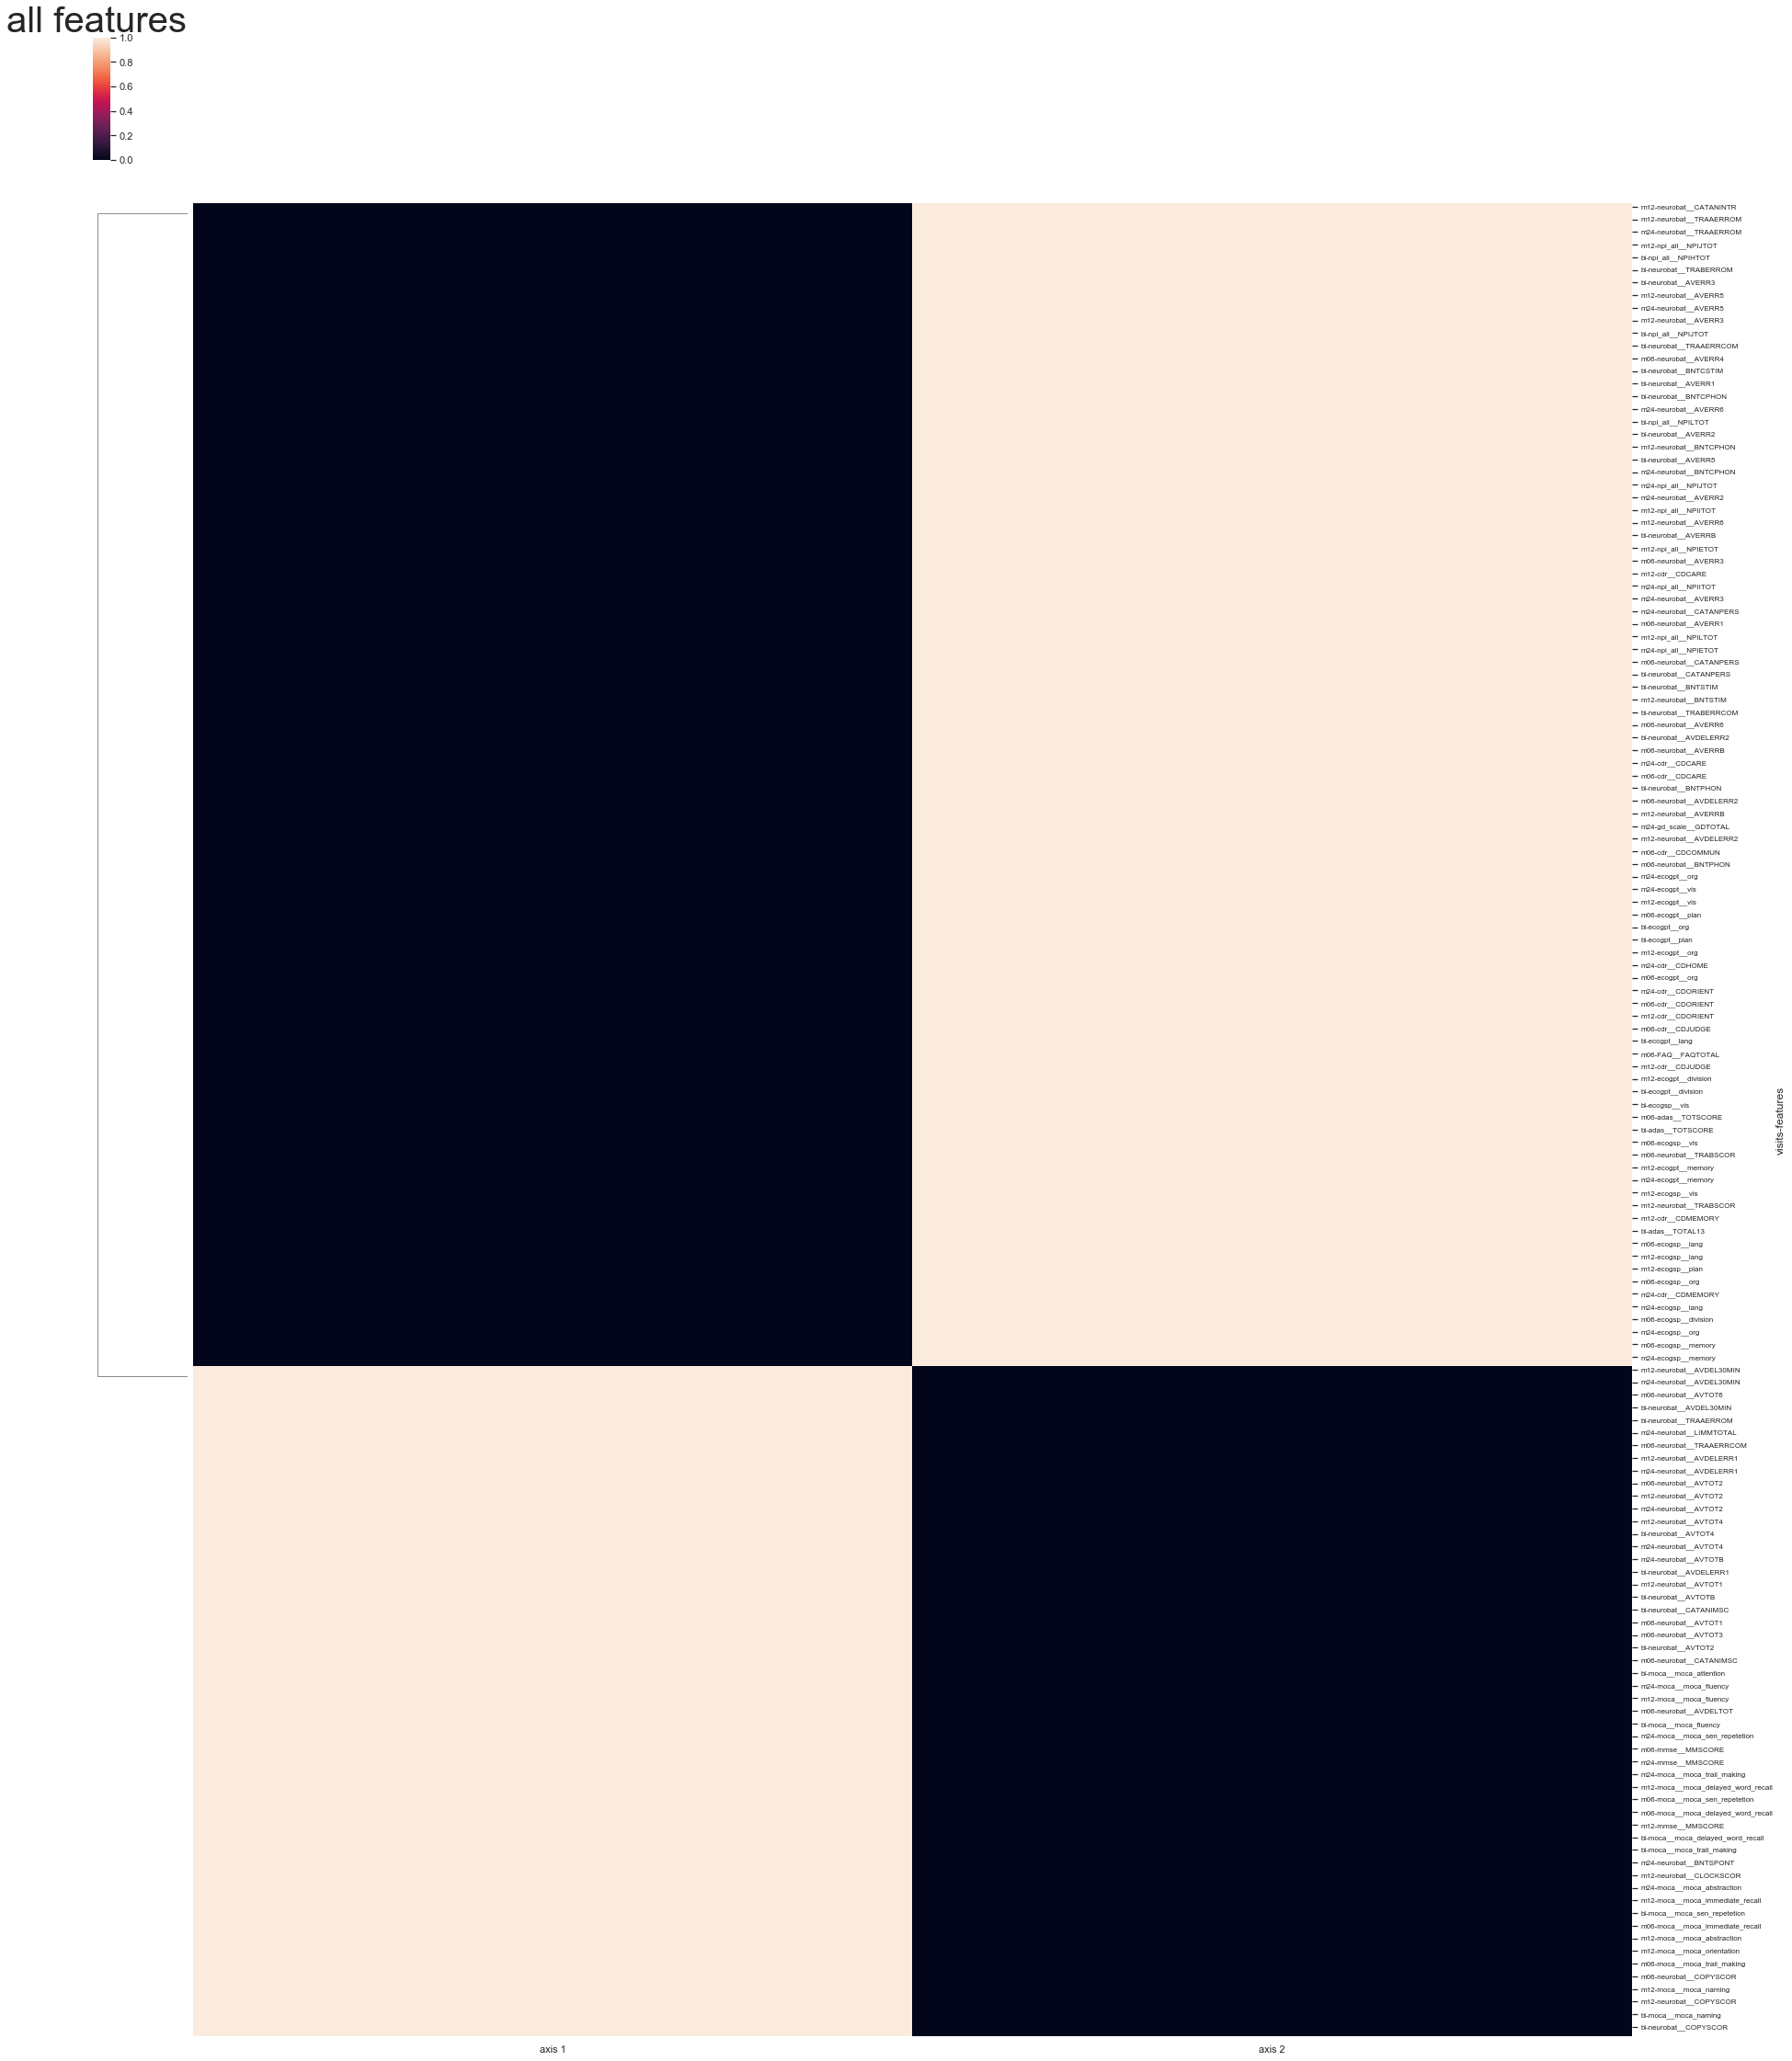

In [9]:
M_W, colors_categories, M_chosen,dignosis,M_H_T2, M_H_T3 = project_data(data, visit)


In [10]:
def plot_side_by_side_2d(M_mci_dem_nmf_proj,Predict, redued_item_24, colors_categories_item_24, case,algorithm):
    mpl.style.use('seaborn-whitegrid')
    mpl.rc('font', size= 40)
    mpl.rc('axes', titlesize= 40)
    # in this function axis 3 is visualizing new predicted values and axis 4 is visualing old values obtained fron data
    Predict1 = Predict.copy(deep = True)
    f9 = plt.figure(figsize=(30,20))
    f9.suptitle("Alzheimer's Progression Space at 24th month\n (Using 12 month of data)", fontsize = 40)
    ax3 = f9.add_subplot(1, 2, 1)
    ax4 = f9.add_subplot(1, 2, 2)
    colors = pd.DataFrame(Predict1.replace([0,1,2,4],['yellow','blue','hotpink','cyan']))
    ax3.scatter(M_mci_dem_nmf_proj[['NMF_2_1']], M_mci_dem_nmf_proj[['NMF_2_2']], c = colors.iloc[:,0], alpha=0.5, s = 700)
    ax3.grid(True)
    ax3.set_xlabel('Cognitive decline', fontsize = 40)
    ax3.set_ylabel('Memory decline', fontsize = 40)
    ax3.set_title(" Classification by Algorithm ", fontsize = 40)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'yellow')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='hotpink')
    ax3.legend((p1,p2,p3), ('low','medium','High'), loc='best', fontsize = 40)
    #ax3.legend((p1,p3), ('low','High'), loc='best')
    ax4.scatter(redued_item_24[['NMF_2_1']], redued_item_24[['NMF_2_2']], c = colors_categories_item_24, alpha=0.5, s = 700)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    ax4.legend((p1,p2,p3), ('Control','MCI','Dementia'), loc='best', fontsize = 40);
    ax4.grid(True)
    ax4.set_xlabel('Cognitive decline', fontsize = 40)
    ax4.set_ylabel('Memory decline', fontsize = 40)
    ax4.set_title(" Original Labels", fontsize = 40)
    plt.setp(ax4.get_xticklabels(), fontsize= 26)
    plt.setp(ax4.get_yticklabels(), fontsize= 26)
    plt.setp(ax3.get_xticklabels(), fontsize= 26)
    plt.setp(ax3.get_yticklabels(), fontsize= 26)
    plt.savefig(address +'\\paper_fig\\'+ 'nmf_side_by_side_24.png',dpi = 200)
    
def plot_nmf_gmm(M_mci_dem_nmf_proj,Predict, redued_item_24, colors_categories_item_24, case,algorithm):
    mpl.style.use('seaborn-whitegrid')
    mpl.rc('font', size= 40)
    mpl.rc('axes', titlesize= 40)
    Predict1 = Predict.copy(deep = True)
    f11 = plt.figure(figsize=(15,20))
    f11.suptitle("Alzheimer's Progression Space at 24th month", fontsize = 40)
    ax5 = f11.add_subplot(1, 1, 1)
    colors = pd.DataFrame(Predict1.replace([0,1,2,4],['yellow','blue','hotpink','cyan']))
    ax5.scatter(M_mci_dem_nmf_proj[['NMF_2_1']], M_mci_dem_nmf_proj[['NMF_2_2']], c = colors.iloc[:,0], alpha=0.5, s = 700)
    ax5.grid(True)
    ax5.set_xlabel('Cognitive decline', fontsize = 40)
    ax5.set_ylabel('Memory decline', fontsize = 40)
    ax5.set_title(" Classification by Algorithm ", fontsize = 40)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'yellow')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='hotpink')
    ax5.legend((p1,p2,p3), ('low','medium','High'), loc='best')
    #ax3.legend((p1,p3), ('low','High'), loc='best')
    plt.setp(ax5.get_xticklabels(), fontsize= 26)
    plt.setp(ax5.get_yticklabels(), fontsize= 26)
    plt.savefig(address + 'nmf_one.png',dpi = 50)      
     
def projections_plain(M_mci_dem_nmf_proj,Predict, redued_item_24, colors_categories_item_24, case,algorithm):
    mpl.style.use('seaborn-whitegrid')
    mpl.rc('font', size= 40)
    mpl.rc('axes', titlesize= 40)
    # in this function axis 3 is visualizing new predicted values and axis 4 is visualing old values obtained fron data
    Predict1 = Predict.copy(deep = True)
    f9 = plt.figure(figsize=(15,20))
    f9.suptitle("Alzheimer's Progression Space at 24th month", fontsize = 40)
    ax4 = f9.add_subplot(1, 1, 1)
    ax4.scatter(redued_item_24[['NMF_2_1']], redued_item_24[['NMF_2_2']], c = colors_categories_item_24, alpha=0.5, s = 700)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    ax4.legend((p1,p2,p3), ('Control','MCI','Dementia'), loc='best', fontsize = 40);
    ax4.grid(True)
    ax4.set_xlabel('Cognitive decline', fontsize = 40)
    ax4.set_ylabel('Memory decline', fontsize = 40)
    ax4.set_title(" Original Labels", fontsize = 40)
    plt.setp(ax4.get_xticklabels(), fontsize= 26)
    plt.setp(ax4.get_yticklabels(), fontsize= 26)
    plt.savefig(address + 'nmf_side_by_side.png',dpi = 200)   
    
def plot_side_by_side_3d(M_mci_dem_nmf_proj,Predict, redued_item_24, colors_categories_item_24, case,algorithm):
    mpl.style.use('seaborn-whitegrid')
    mpl.rc('font', size= 18)
    mpl.rc('axes', titlesize= 18)
    
    # in this function axis 3 is visualizing new predicted values and axis 4 is visualing old values obtained fron data
    Predict1 = Predict.copy(deep = True)
    f10 = plt.figure(figsize=(20,15))
    f10.suptitle("Classification by Algorithm", fontsize = 18)
    ax3 = plt.axes(projection='3d')
    colors = pd.DataFrame(Predict1.replace([0,1,2,4],['yellow','blue','hotpink','cyan']))
    ax3.scatter(M_mci_dem_nmf_proj[['NMF_3_1']], M_mci_dem_nmf_proj[['NMF_3_2']],M_mci_dem_nmf_proj[['NMF_3_3']] ,c = colors.iloc[:,0], alpha=0.8)
    ax3.grid(True)
    ax3.set_xlabel('Cognition', fontsize = 18)
    ax3.set_ylabel('Memory and Depression ', fontsize = 18)
    ax3.set_zlabel('Memory and Depression', fontsize = 18)
    ax3.view_init(30, 30)
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc= 'yellow')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='hotpink')
    ax3.legend((p1,p2,p3), ('low','medium','High'), loc='best')
    ax3.view_init(30, 30)
    #ax3.legend((p1,p3), ('low','High'), loc='best')
    plt.savefig(address + 'nmf_side_by_side_3d_original.png',dpi = 200)

#### Data imputation

#### Functions to plot data in different format

In [11]:
M_mci_dem = M_W
M_mci_dem_nmf_all = M_mci_dem[['NMF_2_1','NMF_2_2']].copy()
M_mci_dem_nmf = M_mci_dem[['NMF_2_1', 'NMF_2_2']]
M_mci_dem_nmf_proj_all = M_mci_dem_nmf_all[~(M_W.DXCHANGE.isin([1]) )] # removing controls
M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_all[['NMF_2_1','NMF_2_2']]
try:
    colors_categories_item_24_no_controls = M_W[~(M_W.DXCHANGE.isin([1]) )]['DXCHANGE'].replace([1,2,3], ['red', 'blue', 'green'])
except:
    pass

# Function to organize color sequence as per high low and medium
def organize_prediction_moca(M_mci_dem_nmf_proj_3d_only,Predict_gmm):
    M_mci_dem_nmf_proj = M_mci_dem_nmf_proj_3d_only
    M_mci_dem_nmf_proj['predicted'] = Predict_gmm
    a = list(pd.unique(Predict_gmm.iloc[:,0]))
    srt = np.empty((len(a),2))
    for i in a:
        a = M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #b =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,1].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        #c =  M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i].iloc[:,0].sum() / len(M_mci_dem_nmf_proj[M_mci_dem_nmf_proj.predicted == i])
        srt[i,1] = a
        srt[i,0] = i
    srt = pd.DataFrame(srt).sort_values([1])
    Predict_gmm.replace([srt.iloc[0,0],srt.iloc[1,0], srt.iloc[2,0] ],[0,1,2], inplace=True)   
    return pd.DataFrame(Predict_gmm)

#### Using GMM for clustering

In [12]:
model_gmm = mixture.GaussianMixture(n_components=3, covariance_type='diag',  random_state = 0)
model_gmm.fit(M_mci_dem_nmf_proj_all) # print(gmm.means_)
# label the predicted and only keep HC and PDs
Predict_gmm = pd.DataFrame(model_gmm.predict(M_mci_dem_nmf_proj))
Predict_gmm.index = M_mci_dem_nmf_proj.index
Predict_gmm = Predict_gmm.reset_index()
Predict_gmm.columns = ['RID','predicted']

## Read save data and predict

In [17]:
address1 = 'C:\\Users\\Vipul Satone\\health data\\ADNI\\sem4\\github_adni_paper_floder\\revision reply\\fig_adas\\'

data = pd.read_csv( address1 + 'data_age_edu_apoe4.csv', index_col = 0)
data1 = pd.merge(data, Predict_gmm, on='RID', how='inner')
data1 = data1.set_index('RID')
print('SHape of data used is {}'.format(data1.shape) )
# data1.head()

SHape of data used is (265, 4)


Nearest Neighbors
[0.42592593 0.27777778 0.38888889 0.53846154 0.43137255]
#####################
Linear SVM
[0.37037037 0.59259259 0.53703704 0.5        0.43137255]
#####################
RBF SVM
[0.25925926 0.16666667 0.42592593 0.44230769 0.43137255]
#####################
Decision Tree
[0.37037037 0.12962963 0.53703704 0.51923077 0.37254902]
#####################
AdaBoost
[0.40740741 0.53703704 0.57407407 0.5        0.41176471]
#####################
Naive Bayes
[0.35185185 0.25925926 0.46296296 0.5        0.45098039]
#####################
Linear Discriminant Analysis
[0.37037037 0.53703704 0.57407407 0.5        0.43137255]
#####################
Quadratic Discriminant Analysis
[0.37037037 0.51851852 0.57407407 0.53846154 0.39215686]
#####################
Logistic Regression
[0.37037037 0.5        0.62962963 0.5        0.41176471]
#####################
Random Forest
[0.37037037 0.11111111 0.2962963  0.42307692 0.41176471]
#####################


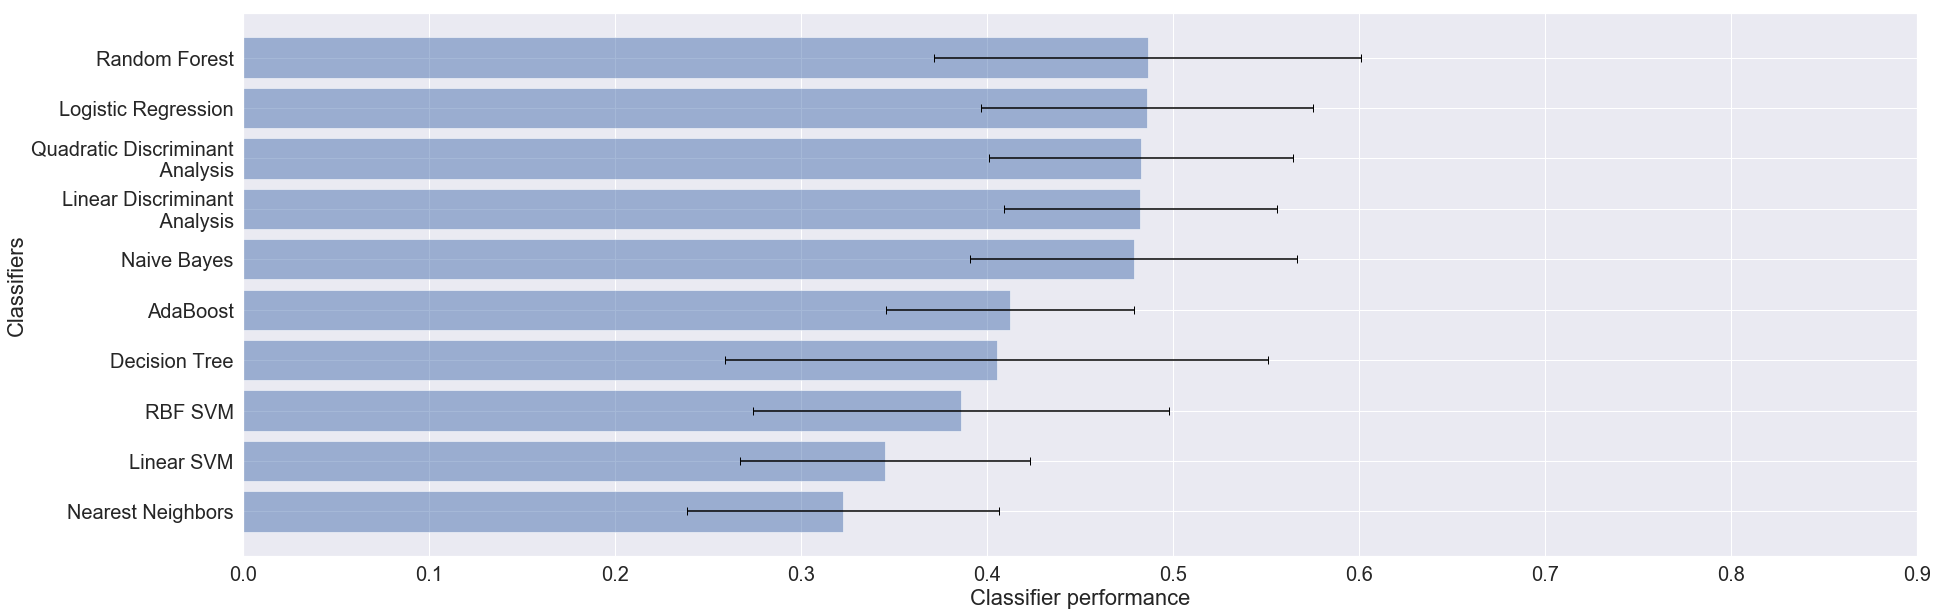

In [18]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
         "Quadratic Discriminant Analysis", "Logistic Regression"
         , "Random Forest"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    LogisticRegression(),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    RandomForestClassifier(n_estimators = 40)]



X_train, X_test, y_train, y_test = train_test_split(data1.iloc[:,0:-1], data1['predicted'], test_size=0.2, random_state=42)

x_full = data1.iloc[:,0:-1]
y_full = data1['predicted']

scores1 = []
score_entry = {}
y_pred = {}
 
list_of_names = []
mean_scores = []
standard_devi = []

for name, clf in zip(names, classifiers):
    pipeline = Pipeline([(name, clf)])
    scores = cross_val_score(pipeline, x_full, y_full, scoring='accuracy', cv=5)
    list_of_names.append(name)
    mean_scores.append( scores.mean() )
    standard_devi.append( scores.std() )
    print(name)
    print(scores)
    print('#####################')

mean_scores, names = zip(*sorted(zip(mean_scores, names)))
fig, ax = plt.subplots( figsize=(30, 10) )
ax.barh(  np.arange(len(names)),mean_scores, xerr=standard_devi, align='center', alpha=0.5, ecolor='black', capsize=4)
ax.set_xlabel('Classifier performance', fontsize = 22)
ax.set_ylabel('Classifiers', fontsize = 22)
plt.xlim( ([0.0,0.90]) )
ax.set_yticks(np.arange(len(names)))

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree", "AdaBoost", "Naive Bayes", "Linear Discriminant\n Analysis",
         "Quadratic Discriminant\n Analysis", "Logistic Regression"
         , "Random Forest"]
ax.set_yticklabels(names,rotation=0 , fontsize = 20 )
ax.set_xticklabels( [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], fontsize = 20 )
ax.xaxis.grid(True)
# plt.title('Comparision of different classifiers for prediction at m48 considering baseline and m12', fontsize = 28)
fig.savefig(address + 'accuracy.png',dpi = 200)
fig.show()

In [19]:
# Grid searh fro finding optimum parameters.Which are as follows. Uncomment code to run this cell
# {'classifier__class_weight': None, 'classifier__max_depth': 5, 'classifier__max_features': 'auto',
# 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 50, 'classifier__random_state': 0}

pipeline = Pipeline([('classifier', RandomForestClassifier())])
scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=5)
mean = scores.mean()
std = scores.std()
print('Mean of the five fold cross validation accuracy = ', mean)
print('Standard Deviation of the five fold cross validation accuracy = ',std)
print(pipeline.get_params())

'''
you can also specify classifications models here
'''
grid = {
    'classifier__n_estimators': [5,10,15,20,25,30,35,40,45,50],\
    'classifier__max_depth' :  [5,10,15,20,25,30,35,40,45,50],\
    'classifier__class_weight':  [None, 'balanced'],\
    'classifier__max_features': ['auto','sqrt','log2', None],\
    'classifier__random_state' : [0],  
    'classifier__min_samples_leaf': [1,2,3,0.1,0.05,0.01]
}
# grid = {
#     'classifier__n_estimators': [50],#[5,10,15,20,25,30,35,40,45,50],\
#     'classifier__max_depth' : [10],#[5,10,15,20,25,30,35,40,45,50],\
#     'classifier__class_weight': [None],#[None, 'balanced'],\
#     'classifier__max_features': ['auto'],#['auto','sqrt','log2', None],\
#     'classifier__random_state' : [0],  
#     'classifier__min_samples_leaf':[3]# [1,2,3,0.1,0.05,0.01]
# }


#{'classifier__class_weight': 'balanced', 'classifier__max_depth': 15, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 3, 'classifier__n_estimators': 40, 'classifier__random_state': 0}

grid_search = GridSearchCV(pipeline, param_grid=grid, scoring='accuracy', n_jobs=1, cv=5)
grid_search.fit(X=x_full, y=y_full)
d = grid_search.best_params_

print("-----------")
print("-----------")
print('best score\n')
print(grid_search.best_score_)
print('best_params\n')
print(grid_search.best_params_)
print(grid_search.best_index_)
print(f"Mean cv accuracy on test set {grid_search.cv_results_['mean_test_score'][grid_search.best_index_]} \n")
print(f"Standard deviation on test set {grid_search.cv_results_['std_test_score'][grid_search.best_index_]} \n")
print(f"Mean cv accuracy on train set {grid_search.cv_results_['mean_train_score'][grid_search.best_index_]} \n")
print(f"Standard deviation on train set {grid_search.cv_results_['std_train_score'][grid_search.best_index_]} \n")
print(grid_search.best_score_)
ci95_low = grid_search.cv_results_['mean_test_score'][grid_search.best_index_] - (1.96*  grid_search.cv_results_['std_test_score'][grid_search.best_index_]/ math.sqrt(5) )
ci95_hi = grid_search.cv_results_['mean_test_score'][grid_search.best_index_] + (1.96*  grid_search.cv_results_['std_test_score'][grid_search.best_index_]/ math.sqrt(5) )
print(f"95 % CI {ci95_low} and {ci95_hi} \n")

Mean of the five fold cross validation accuracy =  0.36808200307916705
Standard Deviation of the five fold cross validation accuracy =  0.014236244942262154
{'memory': None, 'steps': [('classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))], 'classifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_s

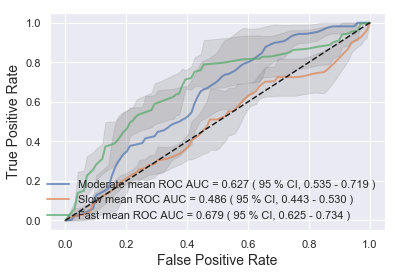

In [20]:
# 5 fold cv

X,Y = data1.iloc[:,0:-1],data1['predicted']
n_classes = y_train.unique()
cv = StratifiedKFold(n_splits=5)
for k in n_classes:
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for train, test in cv.split(X,Y):
            pipeline = Pipeline([('classifier', RandomForestClassifier(max_features= d['classifier__max_features'],min_samples_leaf=d['classifier__min_samples_leaf'] ,  n_estimators=d['classifier__n_estimators'], max_depth= d['classifier__max_depth'],class_weight=d['classifier__class_weight'], random_state= d['classifier__random_state'] ))])
            pipeline.fit(X.iloc[train], Y.iloc[train]==k)
            preds  = pipeline.predict_proba(X.iloc[test])
            label =  Y.iloc[test] == k
            fpr, tpr, _ = metrics.roc_curve(label, preds[:,1]) # Fpr and tpr calculated for test and train so Auc is also fro test and train
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = metrics.auc(fpr, tpr)
            aucs.append(roc_auc)
            i += 1
            
    class_name = 'Controls' if k==3 else 'Slow' if k==0 else 'Moderate' if k==1 else 'Fast'
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ci95_hi = f'{mean_auc + 1.96*(std_auc/ math.sqrt(len(aucs)) ) :.3f}' 
    ci95_low = f'{mean_auc - 1.96*(std_auc/ math.sqrt(len(aucs)) ):.3f}'
    plt.plot(mean_fpr, mean_tpr,label= f'{class_name} mean ROC AUC = {mean_auc:.3f} ( 95 % CI, {ci95_low} - {ci95_hi} )' ,lw=2, alpha=.7)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)

plt.figure(1, figsize=(18, 18))
plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([-0.025, 1.025])
# plt.ylim([-0.025, 1.025])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
#plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig(address + 'auc_ap_edu.png',dpi = 200)
plt.show()

In [24]:
a = pd.read_csv('..\\health data\\ADNI\\sem4\\github_adni_paper_floder\\revision reply\\fig_adas\\result.csv')
a['val(%)'] = a['val(%)']*100
a['err)'] = a['err']*100

In [25]:
a

,measure,month,val(%),err,err)
0,Accuracy,Pred. at m24 using data till BL,81.13,0.0000,0.00
1,(AUC) Slow,Pred. at m24 using data till BL,94.30,0.0300,3.00
2,(AUC) Moderate,Pred. at m24 using data till BL,84.20,0.0600,6.00
3,(AUC) Fast,Pred. at m24 using data till BL,94.20,0.0400,4.00
4,Accuracy,Pred. at m24 using data till m12,92.45,0.0069,0.69
5,(AUC) Slow,Pred. at m24 using data till m12,98.50,0.0100,1.00
6,(AUC) Moderate,Pred. at m24 using data till m12,91.50,0.0300,3.00
7,(AUC) Fast,Pred. at m24 using data till m12,99.00,0.0100,1.00
8,Accuracy,Pred. at m48 using data till BL,83.06,0.0160,1.60
9,(AUC) Slow,Pred. at m48 using data till BL,94.30,0.0300,3.00


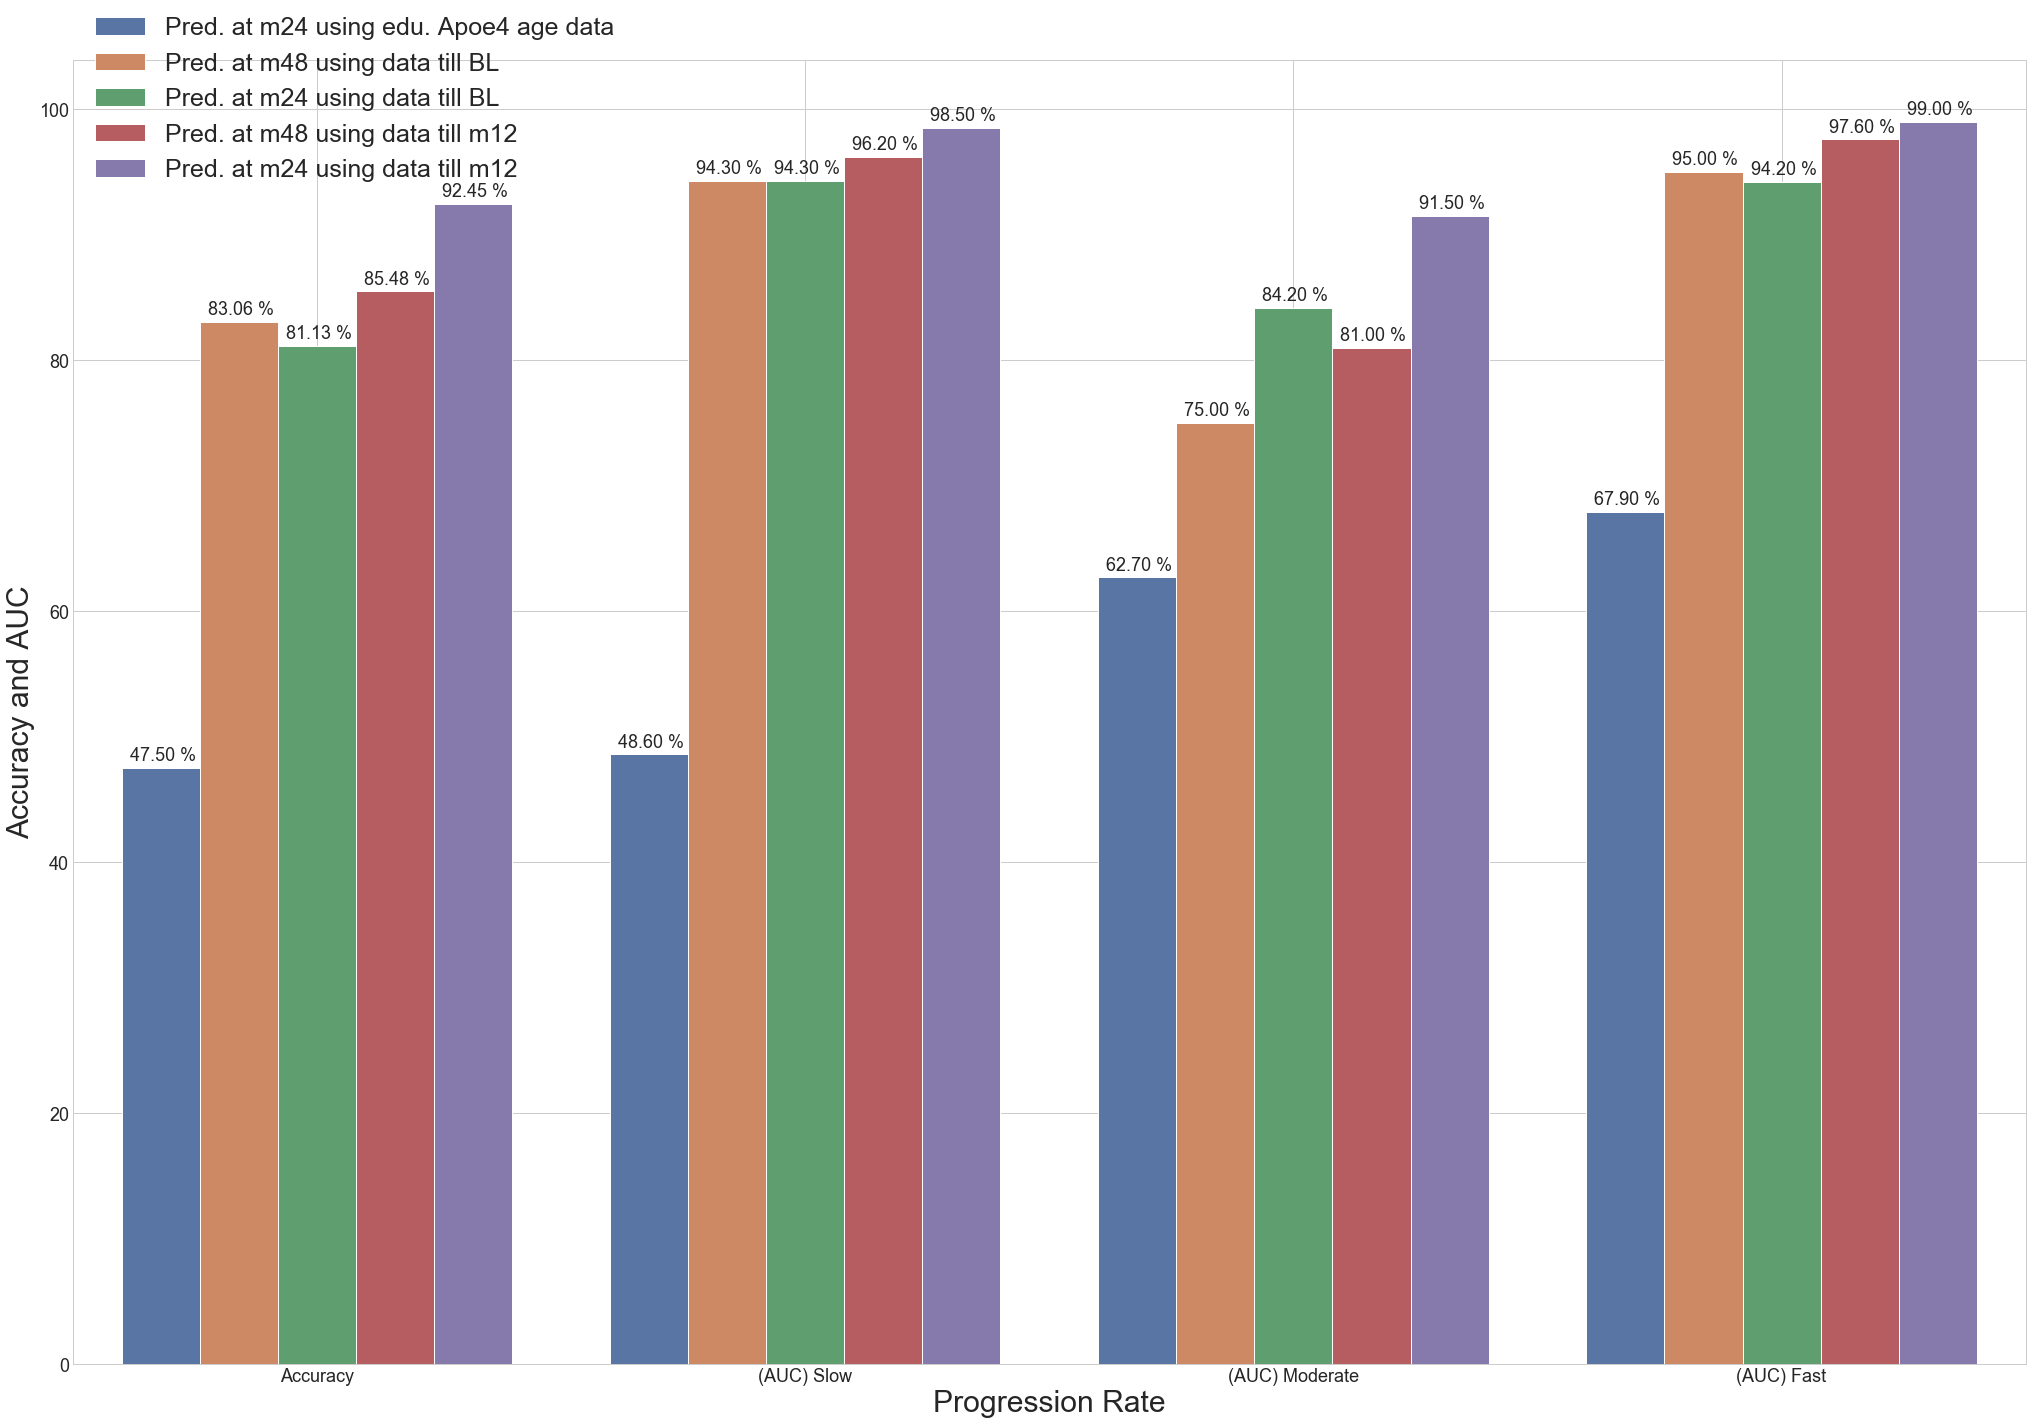

In [26]:
mpl.style.use('seaborn-whitegrid')
def data_fn(data):
    return(data)
plt.figure(figsize=(35, 24)) 
aa = a.groupby(['measure','month']).apply(data_fn)
axis = sns.barplot(x="measure", y="val(%)", hue="month", hue_order =['Pred. at m24 using edu. Apoe4 age data', 'Pred. at m48 using data till BL' , 'Pred. at m24 using data till BL' , 'Pred. at m48 using data till m12' , 'Pred. at m24 using data till m12'], order = ['Accuracy','(AUC) Slow','(AUC) Moderate','(AUC) Fast'] ,data=aa)
axis.tick_params(labelsize=18)
axis.set_xlabel("Progression Rate",fontsize=18)
axis.set_ylabel("acc",fontsize=18)
axis.grid(True)
plt.setp(axis.get_legend().get_texts(), fontsize='26') # for legend text
plt.setp(axis.get_legend().get_title(), fontsize='26') # for legend title
for p in axis.patches:
    axis.annotate("%.2f" % p.get_height() + ' %', (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', rotation=0, xytext=(2, 12), textcoords='offset points',size=18)
# plt.setp(ax.get_xticklabels(), fontsize=18) 
plt.legend(loc="upper left",  fontsize=25 ,bbox_to_anchor=(0, 1.05) )
plt.xlabel('Progression Rate', fontsize = 30)
plt.ylabel('Accuracy and AUC', fontsize = 30)
plt.savefig(address + 'agg_graph.png',dpi = 200)